In [21]:
import os
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [2]:
from get_rainfall_data import load_chirps_data

In [3]:
import pandas as pd
import numpy as np
import xarray as xr
import rasterio as rio
import rioxarray
from shapely.geometry import shape
import seaborn as sns
import geopandas as gpd

In [41]:
from s2cloudless import S2PixelCloudDetector
from odc.algo import to_rgba
from odc.stac import stac_load, configure_rio
import dask
from deafrica_tools.plotting import rgb, display_map
from pystac_client import Client
import matplotlib.dates as mdates

-  Digital Earth Africa data is stored on S3 in Cape Town, Africa. 
- To load the data, we must configure rasterio with the appropriate AWS S3 endpoint.

In [5]:
os.environ["AWS_S3_ENDPOINT"] = "s3.af-south-1.amazonaws.com"
os.environ["AWS_NO_SIGN_REQUEST"] = "true"

- The configuration below must be used when loading any Digital Earth Africa data through the STAC API.

In [28]:
client = dask.distributed.Client()

configure_rio(
    cloud_defaults = True,
    aws = {"aws_unsigned": True},
    client = client
)

- Open the stac catalog

In [29]:
catalog = Client.open("https://explorer.digitalearth.africa/stac")

In [9]:
farmers_df = pd.read_csv('dataset.csv')

In [23]:
start_date = '2020-01-01'
end_date = '2020-08-01'
lat,lon = farmers_df.latitude.iloc[0],farmers_df.longitude.iloc[0]
ds_rf_daily = load_chirps_data(lat, lon, start_date, end_date)

Found: 214 datasets


In [49]:
ds_rf_daily = ds_rf_daily.where(ds_rf_daily !=-9999)

In [50]:
ds_rf_daily_mean = ds_rf_daily['rainfall'].mean(['longitude','latitude']).to_dataframe()
ds_rf_daily_mean = ds_rf_daily_mean.reset_index()

In [51]:
ds_rf_daily_mean['day'] = ds_rf_daily_mean['time'].apply(lambda x: x.date())

In [52]:
ds_rf_daily_mean = ds_rf_daily_mean[['day','rainfall']].set_index('day')

Text(0.5, 1.0, 'Daily Rainfall from January to August 2020')

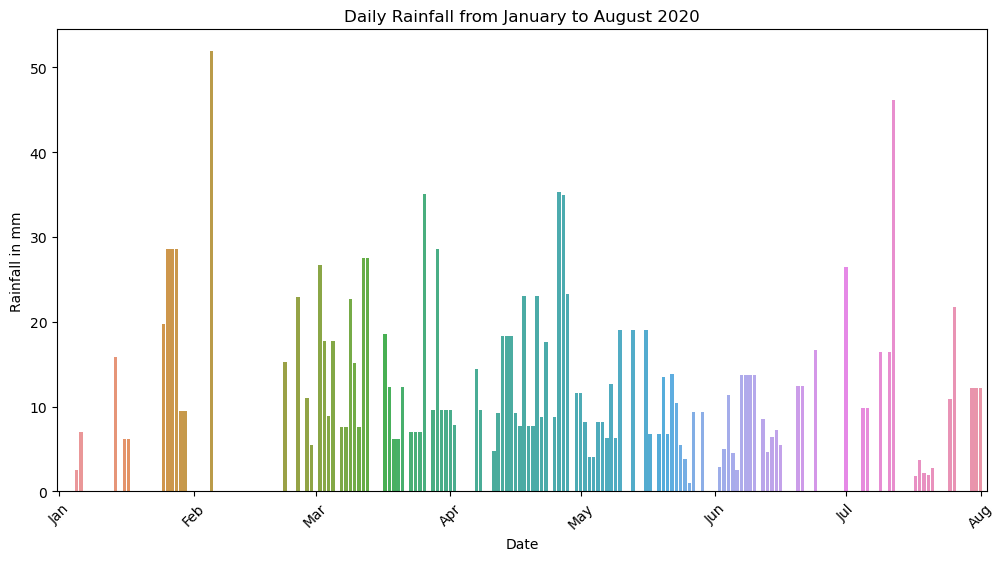

In [53]:
fig, ax = plt.subplots(1, figsize=(12,6))
sns.barplot(data = ds_rf_daily_mean, x = ds_rf_daily_mean.index, y = 'rainfall')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Rainfall in mm")
plt.title("Daily Rainfall from January to August 2020")